# Find the Measured Velocities


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


def recursive_root(path: str, find="sumo-uc-23"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [3]:
from src.walk_configs import walk_configs


In [4]:
experiment_path = Path(
    "/Volumes/BittleLab/7 DOE Project/sumo-uc-23/CarFollowingDefaults/EIDM_IDM_KraussAB"
)


In [5]:
configs = list(walk_configs(experiment_path))

In [6]:
len(configs)

90

### Read the File


In [7]:
import pandas as pd

def get_summary_df(config, box: str, additional_params: dict = None) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    df = pd.read_parquet(Path(config.Metadata.cwd) / f"{box}_summary_df.parquet")
    for key, value in additional_params.items():
        df[key] = value
    return df

In [8]:
west_thru_dfs = []
east_thru_dfs = []
for config in tqdm(configs):
    additional_params = {
        "carFollowingModel": config.Blocks.CFSimpleConfig.cf_params.carFollowingModel,
        "seed": config.Blocks.SeedConfig.seed,
    }
    west_thru_dfs.append(
        get_summary_df(config, box="Radar136_West_thru", additional_params=additional_params)
    )
    east_thru_dfs.append(
        get_summary_df(config, box="Radar137_East_thru", additional_params=additional_params)
    )
east_thru_df = pd.concat(east_thru_dfs)
west_thru_df = pd.concat(west_thru_dfs)

## Read the RW Data

In [9]:
rw_df = pd.read_parquet(ROOT / "data" / "rw_east_thru_summary.parquet")

## Plot the Histograms

(0.0, 6.0)

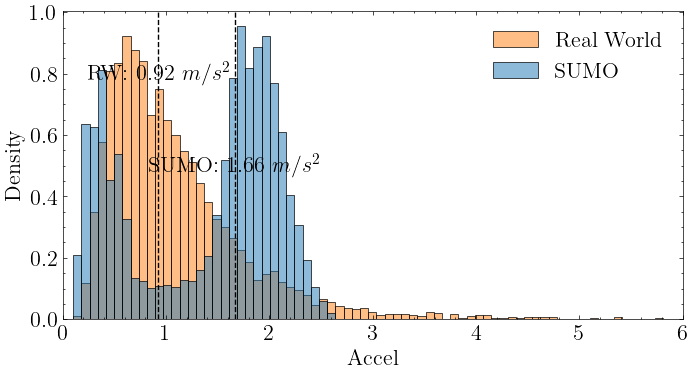

In [29]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({'font.size': 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = west_thru_df[(west_thru_df["r2"] > 0.9) & (west_thru_df['type'] == "accel")]
accel_sumo_df = accel_sumo_df[accel_sumo_df["carFollowingModel"] == "IDM"]

# concatenate the rw data
accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "accel")].copy()
accel_rw_df["carFollowingModel"] = "Real World"

plot_df = pd.concat([accel_sumo_df, accel_rw_df])


sns.histplot(data=plot_df, x="slope", hue="carFollowingModel", stat="density", ax=ax,  palette=["#1f77b4", "#ff7f0e"], common_norm=False)
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)
# set the legend labels
ax.legend(labels=["Real World", "SUMO"])
# # add the rw data
# accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "accel")]
# sns.histplot(data=accel_rw_df, x="slope", stat="density", ax=ax)

# add a vertical line at the mean
median_sumo = plot_df.loc[plot_df['carFollowingModel'] == "IDM", "slope"].median()
median_rw = plot_df.loc[plot_df['carFollowingModel'] == "Real World", "slope"].median()
ax.axvline(median_sumo, color="black", linestyle="--")
ax.axvline(median_rw, color="black", linestyle="--")
# add text to the vertical line
ax.text(median_sumo, 0.5, f"SUMO: {median_sumo:.2f} $m/s^2$", rotation=0, va="center", ha="center")
ax.text(median_rw, 0.8, f"RW: {median_rw:.2f} $m/s^2$", rotation=0, va="center", ha="center")



# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(0, 6)


(-6.0, 0.0)

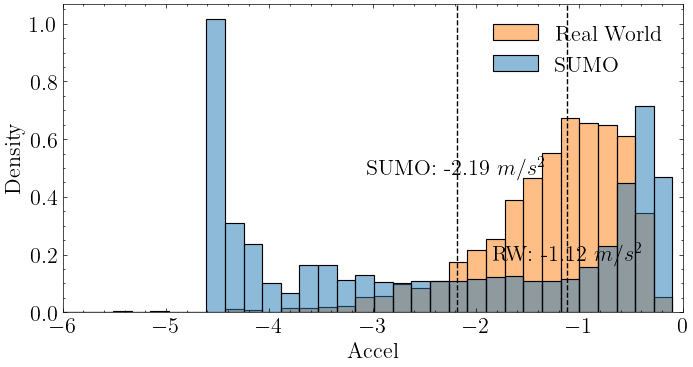

In [28]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({'font.size': 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = west_thru_df[(west_thru_df["r2"] > 0.9) & (west_thru_df['type'] == "decel")]
accel_sumo_df = accel_sumo_df[accel_sumo_df["carFollowingModel"] == "IDM"]

# concatenate the rw data
accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "decel")].copy()
accel_rw_df["carFollowingModel"] = "Real World"

plot_df = pd.concat([accel_sumo_df, accel_rw_df])

sns.histplot(data=plot_df, x="slope", hue="carFollowingModel", stat="density", ax=ax,  palette=["#1f77b4", "#ff7f0e"], common_norm=False)
ax.legend_.set_title(None)
ax.legend(labels=["Real World", "SUMO"])

# add a vertical line at the mean
median_sumo = plot_df.loc[plot_df['carFollowingModel'] == "IDM", "slope"].median()
median_rw = plot_df.loc[plot_df['carFollowingModel'] == "Real World", "slope"].median()
ax.axvline(median_sumo, color="black", linestyle="--")
ax.axvline(median_rw, color="black", linestyle="--")
# add text to the vertical line
ax.text(median_sumo, 0.5, f"SUMO: {median_sumo:.2f} $m/s^2$", rotation=0, va="center", ha="center")
ax.text(median_rw, 0.2, f"RW: {median_rw:.2f} $m/s^2$", rotation=0, va="center", ha="center")


# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(-6, 0)


(0.0, 3.0)

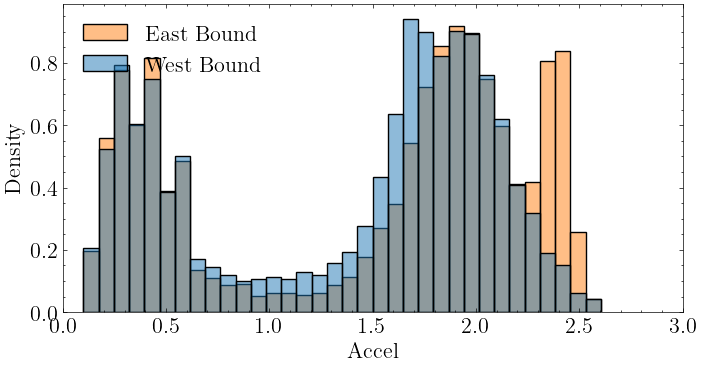

In [85]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')
fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({'font.size': 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = west_thru_df[(west_thru_df["r2"] > 0.9) & (west_thru_df['type'] == "accel")]
accel_sumo_df = accel_sumo_df[accel_sumo_df["carFollowingModel"] == "IDM"]
accel_sumo_df['Approach'] = 'Eastbound'

east_accel_sumo_df = east_thru_df[(east_thru_df["r2"] > 0.9) & (east_thru_df['type'] == "accel")]
east_accel_sumo_df = east_accel_sumo_df[east_accel_sumo_df["carFollowingModel"] == "IDM"]
east_accel_sumo_df['Approach'] = 'Westbound'


plot_df = pd.concat([accel_sumo_df, east_accel_sumo_df])
sns.histplot(data=plot_df, x="slope", hue="Approach", stat="density", ax=ax,  palette=["#1f77b4", "#ff7f0e"], common_norm=False)
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)
# set the legend labels
ax.legend(labels=["East Bound", "West Bound"])
# add a vertical line at the mean
# median_sumo = plot_df.loc[plot_df['carFollowingModel'] == "IDM", "slope"].median()
# median_rw = plot_df.loc[plot_df['carFollowingModel'] == "Real World", "slope"].median()
# ax.axvline(median_sumo, color="black", linestyle="--")
# ax.axvline(median_rw, color="black", linestyle="--")
# # add text to the vertical line
# ax.text(median_sumo, 0.5, f"SUMO: {median_sumo:.2f} $m/s^2$", rotation=0, va="center", ha="center")
# ax.text(median_rw, 0.8, f"RW: {median_rw:.2f} $m/s^2$", rotation=0, va="center", ha="center")



# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(0, 3)


(-6.0, 0.0)

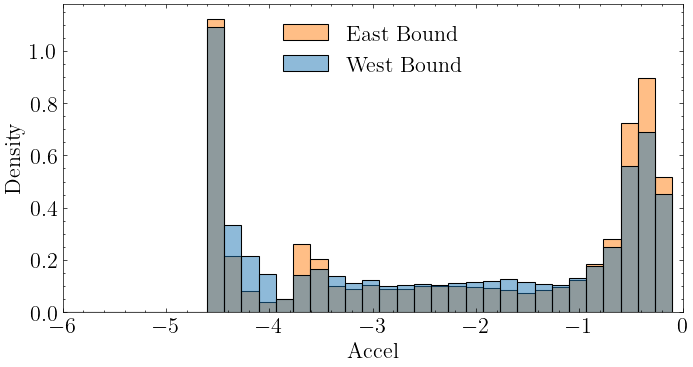

In [84]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')
fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({'font.size': 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = west_thru_df[(west_thru_df["r2"] > 0.9) & (west_thru_df['type'] == "decel")]
accel_sumo_df = accel_sumo_df[accel_sumo_df["carFollowingModel"] == "IDM"]
accel_sumo_df['Approach'] = 'Eastbound'

east_accel_sumo_df = east_thru_df[(east_thru_df["r2"] > 0.9) & (east_thru_df['type'] == "decel")]
east_accel_sumo_df = east_accel_sumo_df[east_accel_sumo_df["carFollowingModel"] == "IDM"]
east_accel_sumo_df['Approach'] = 'Westbound'


plot_df = pd.concat([accel_sumo_df, east_accel_sumo_df])
sns.histplot(data=plot_df, x="slope", hue="Approach", stat="density", ax=ax,  palette=["#1f77b4", "#ff7f0e"], common_norm=False)
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)
# set the legend labels
ax.legend(labels=["East Bound", "West Bound"])
# add a vertical line at the mean
# median_sumo = plot_df.loc[plot_df['carFollowingModel'] == "IDM", "slope"].median()
# median_rw = plot_df.loc[plot_df['carFollowingModel'] == "Real World", "slope"].median()
# ax.axvline(median_sumo, color="black", linestyle="--")
# ax.axvline(median_rw, color="black", linestyle="--")
# # add text to the vertical line
# ax.text(median_sumo, 0.5, f"SUMO: {median_sumo:.2f} $m/s^2$", rotation=0, va="center", ha="center")
# ax.text(median_rw, 0.8, f"RW: {median_rw:.2f} $m/s^2$", rotation=0, va="center", ha="center")



# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(-6, 0)


In [30]:
rw_df.head()

,vehicle_id,mean_time,total_seconds,break,y0,speed,slope,r2,rmse,start,end,type,minimum_time
0,55583,2022-05-23 17:15:55.730996,20.017547,0,20.491891,19.863639,-0.523991,0.873612,0.143615,0.000000,2.428704,decel,2.428704
1,55583,2022-05-23 17:15:55.730996,20.017547,1,23.363228,11.487458,-1.706242,0.997292,0.231500,2.428704,11.532395,decel,9.103691
2,55583,2022-05-23 17:15:55.730996,20.017547,2,18.846501,1.894408,-1.314586,0.797754,0.537509,11.532395,14.348563,undefined,2.816168
3,55583,2022-05-23 17:15:55.730996,20.017547,3,-0.250477,0.008256,0.016347,0.177807,0.031118,14.348563,17.352263,cruise,3.003700
4,55583,2022-05-23 17:15:55.730996,20.017547,4,-13.600174,1.062318,0.785681,0.932057,0.160904,17.352263,20.017547,accel,2.665284


In [80]:
cruise_df = rw_df.loc[(rw_df["type"] == "cruise") & (rw_df["speed"] > 15) & (rw_df["rmse"] < 0.02)].copy()
cruise_df["speed"] = cruise_df["speed"] * 2.23694

array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

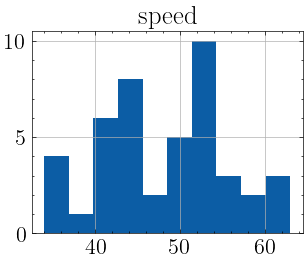

In [81]:
# scatter plot of the data
cruise_df.hist(column="speed", )

In [82]:
cruise_df['speed'].describe()

count    44.000000
mean     48.194663
std       7.517375
min      33.931664
25%      42.682669
50%      48.640121
75%      53.562594
max      62.983520
Name: speed, dtype: float64

In [68]:
slow_down_vehicles = rw_df.groupby("vehicle_id")['type'].apply(lambda x: any(x.str.contains("decel")))

In [69]:
slow_down_vehicles.sum() / slow_down_vehicles.shape[0]

0.8923151047940255

In [70]:
keep_vehicles = slow_down_vehicles[slow_down_vehicles == False].index

array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

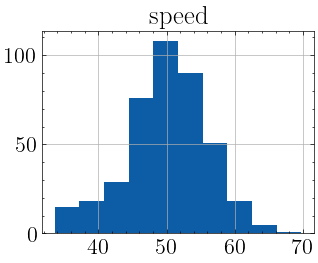

In [71]:
cruise_df.loc[cruise_df.vehicle_id.isin(keep_vehicles)].hist(column="speed", )